<a href="https://colab.research.google.com/github/dyjdlopez/icpep-ai-workshop-2021/blob/main/day4/ICpEP_AI_D4_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Engineering AI Models
Copyright D.Lopez 2021 | All Rights reserved <br><br>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets
import tensorflow_datasets as tfds

In [ ]:
histories = []

## Part 1: More Regularization Techniques
Regularizations are techniques used to reduce the error by fitting a function appropriately on the given training set and avoid overfitting. We'll try to implement regularization through creating a classifier from a pre-existing dataset from the TensorFlow dataset library [[1]](https://towardsdatascience.com/regularization-an-important-concept-in-machine-learning-5891628907ea).



In [ ]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

In [ ]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3


In [ ]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = 224
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Here we may switch between bigger or smaller image sized that we will train our model on.
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 224
Input image shape (reduced): (224, 224, 3)


Input image size: 224
Input image shape: (224, 224, 3)


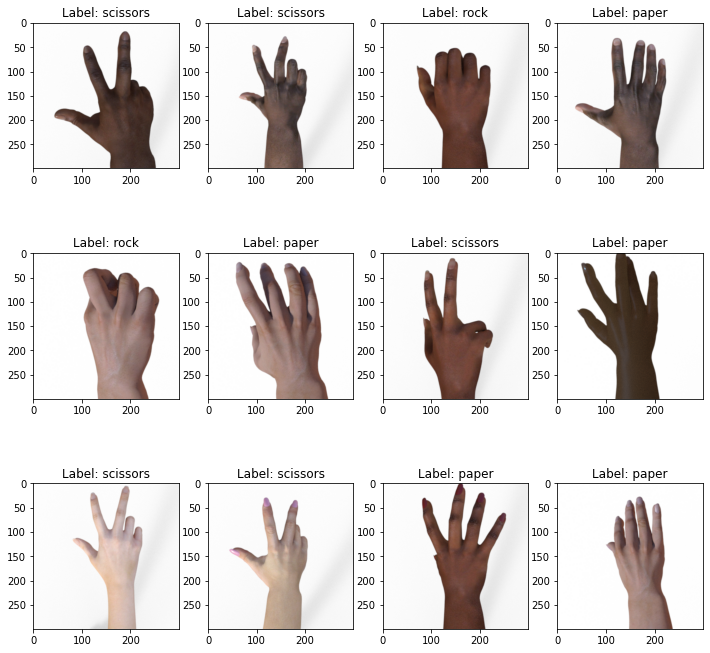

In [ ]:
get_label_name = dataset_info.features['label'].int2str
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

preview_dataset(dataset_train_raw)

In [ ]:
def format_example(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [ ]:
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

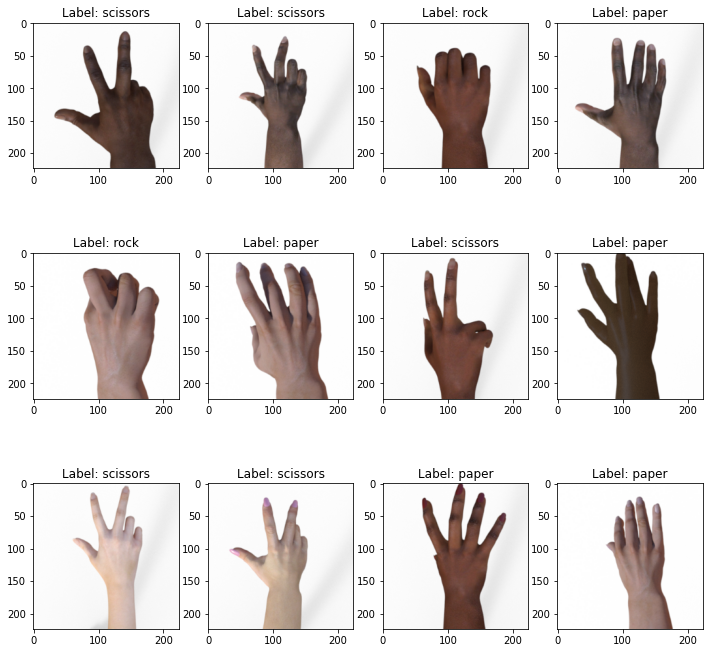

In [ ]:
preview_dataset(dataset_train)

### 1.1 Data Augmentation

Just like our previous session, we can enforce regularization by increasing the variety and volume of the dataset through data augmentation. We'll try to use some augmentation techniques using custom functions.

In [ ]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [ ]:
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

In [ ]:
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [ ]:
def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

In [ ]:
def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    return image, label

In [ ]:
dataset_train_augmented = dataset_train.map(augment_data)

In [ ]:
BATCH_SIZE = 32

dataset_train_augmented_shuffled = dataset_train_augmented.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_augmented_shuffled = dataset_train_augmented.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

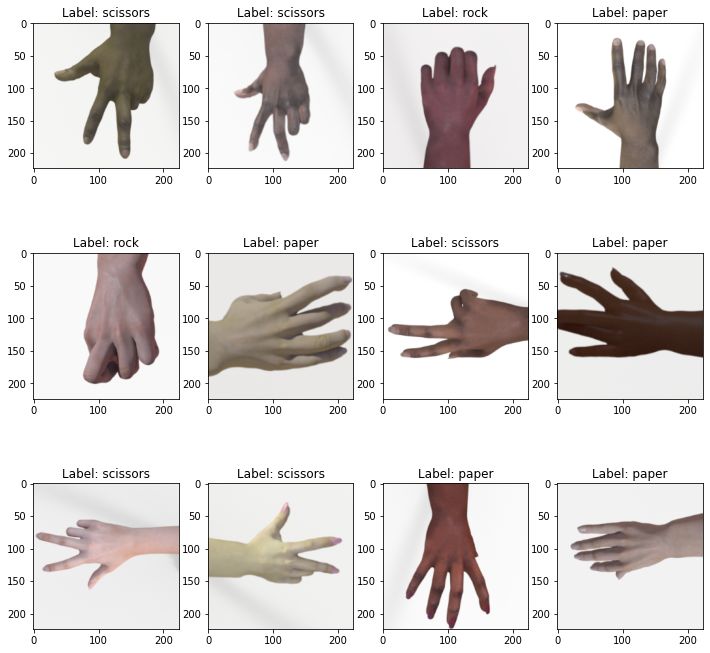

In [ ]:
preview_dataset(dataset_train_augmented)

In [ ]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=INPUT_IMG_SHAPE),
          tf.keras.layers.MaxPooling2D((2,2)),
          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
          tf.keras.layers.MaxPooling2D((2,2)),
          tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')      
])

model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 109, 109, 64)      73792     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 52, 52, 32)        18464     
_________________________________________________________________
flatten_6 (Flatten)          (None, 86528)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

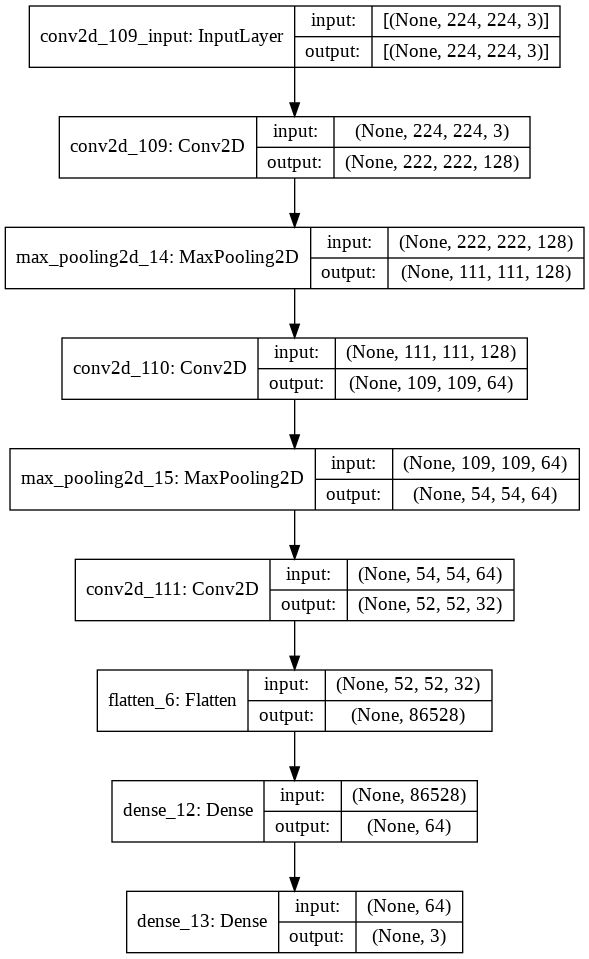

In [ ]:
 tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 78
validation_steps: 11


In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy'
    # monitor='val_loss'
)

In [ ]:
training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        early_stopping_callback,
    ],
    verbose=1
)

Epoch 1/5
78/78 [==============================] - 37s 467ms/step - loss: 1.6429 - accuracy: 0.3786 - val_loss: 1.0105 - val_accuracy: 0.5369
Epoch 2/5
78/78 [==============================] - 35s 455ms/step - loss: 1.0465 - accuracy: 0.5299 - val_loss: 0.6094 - val_accuracy: 0.7500
Epoch 3/5
78/78 [==============================] - 35s 459ms/step - loss: 0.5600 - accuracy: 0.7779 - val_loss: 0.6687 - val_accuracy: 0.7273
Epoch 4/5
78/78 [==============================] - 35s 451ms/step - loss: 0.4408 - accuracy: 0.8454 - val_loss: 0.8388 - val_accuracy: 0.5795
Epoch 5/5
78/78 [==============================] - 34s 446ms/step - loss: 0.6020 - accuracy: 0.7597 - val_loss: 0.6284 - val_accuracy: 0.7784


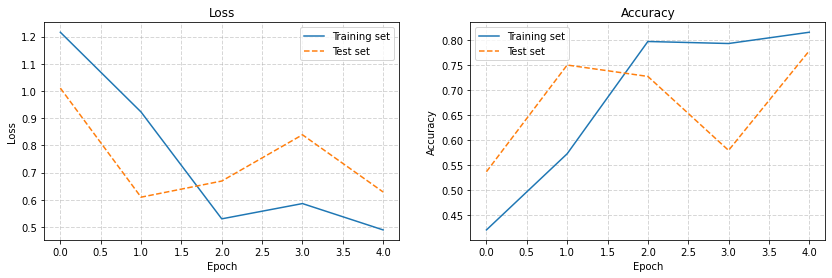

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

render_training_history(training_history)

In [ ]:
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

12/12 [==============================] - 1s 102ms/step - loss: 0.6121 - accuracy: 0.7849
Training loss:  0.21739420294761658
Training accuracy:  0.9277777671813965


Test loss:  0.612140417098999
Test accuracy:  0.7849462628364563


### 1.2 Dropout
Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel.

During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer [[2]](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/). By dropping a unit out, we mean temporarily removing it from the network, along with all its incoming and outgoing connections [[3]](https://jmlr.org/papers/v15/srivastava14a.html).

Check out TensorFlow's [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout).

![image](https://www.globalsoftwaresupport.com/wp-content/uploads/2018/02/ezgif.com-video-to-gif-14.gif)



In [ ]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=INPUT_IMG_SHAPE),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.MaxPooling2D((2,2)),
          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.MaxPooling2D((2,2)),
          tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(64, activation='relu'),
          
          tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')      
])

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        early_stopping_callback,
    ],
    verbose=1
)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_121 (Conv2D)          (None, 222, 222, 128)     3584      
_________________________________________________________________
dropout_5 (Dropout)          (None, 222, 222, 128)     0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 109, 109, 64)      73792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 52, 52, 32)       

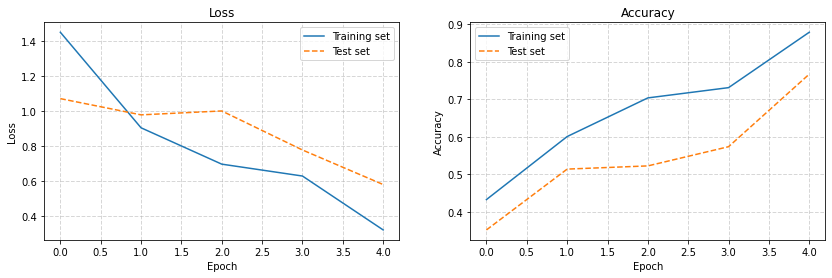

12/12 [==============================] - 1s 89ms/step - loss: 0.5701 - accuracy: 0.7715
Training loss:  0.16794423758983612
Training accuracy:  0.9698412418365479


Test loss:  0.5700944066047668
Test accuracy:  0.7715053558349609


In [ ]:
render_training_history(training_history)
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

### 1.3 Batch Normalization

Training Deep Neural Networks is complicated by the fact that the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities. We refer to the change in the distributions of internal nodes of a deep network, in the course of training, as Internal Covariate Shift [[4]](https://arxiv.org/abs/1502.03167). 

Check out TensorFlow's [BatchNorm](tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization).



In [ ]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=INPUT_IMG_SHAPE),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2,2)),
          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),          
          tf.keras.layers.MaxPooling2D((2,2)),
          tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')      
])

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        early_stopping_callback,
    ],
    verbose=1
)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_139 (Conv2D)          (None, 222, 222, 128)     3584      
_________________________________________________________________
batch_normalization_102 (Bat (None, 222, 222, 128)     512       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 109, 109, 64)      73792     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 52, 52, 32)        18464     
_________________________________________________________________
flatten_16 (Flatten)         (None, 86528)           

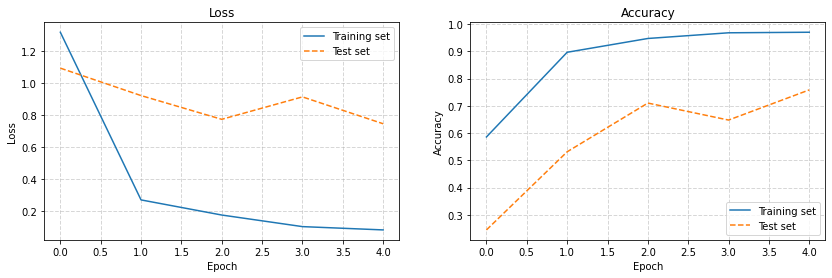

12/12 [==============================] - 1s 94ms/step - loss: 0.7413 - accuracy: 0.7608
Training loss:  0.10548651218414307
Training accuracy:  0.973809540271759


Test loss:  0.7413279414176941
Test accuracy:  0.7607526779174805


In [ ]:
render_training_history(training_history)
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

## Part 2: Transfer Learning

Transfer learning aims at improving the performance of target learners on target domains by transferring the knowledge contained in different but related source domains [[5]](https://arxiv.org/pdf/1911.02685.pdf). Thus, transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task [[6]](https://machinelearningmastery.com/transfer-learning-for-deep-learning/#:~:text=Transfer%20learning%20is%20a%20machine,model%20on%20a%20second%20task.).

<b>Freezing Layers</b>

Freezing a layer prevents its weights from being modified. This technique is often used in transfer learning, where the base model(trained on some other dataset)is frozen. If you don’t want to modify the weights of a layer, the backward pass to that layer can be completely avoided, resulting in a significant speed boost. For e.g. if half your model is frozen, and you try to train the model, it will take about half the time compared to a fully trainable model. On the other hand, you still need to train the model, so if you freeze it too early, it will give inaccurate predictions [[6]](https://www.kdnuggets.com/2017/08/train-deep-learning-faster-freezeout.html).

### 2.1 Inception
![image](https://miro.medium.com/max/512/1*cwR_ezx0jliDvVUV6yno5g.jpeg)

There are 4 versions. The first GoogLeNet must be the Inception-v1 [[7]](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf), but there are numerous typos in Inception-v3 [[8]](https://arxiv.org/abs/1512.00567) which lead to wrong descriptions about Inception versions. These maybe due to the intense ILSVRC competition at that moment. Consequently, there are many reviews in the internet mixing up between v2 and v3. Some of the reviews even think that v2 and v3 are the same with only some minor different settings [[9]](https://sh-tsang.medium.com/review-inception-v3-1st-runner-up-image-classification-in-ilsvrc-2015-17915421f77c).

![image](https://cloud.google.com/tpu/docs/images/inceptionv3onc--oview.png)


In [ ]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

--2021-01-29 18:31:41--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 74.125.28.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   171MB/s    in 0.5s    

2021-01-29 18:31:41 (171 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = INPUT_IMG_SHAPE, 
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(local_weights_file)

In [ ]:
# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_142 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_103 (BatchN (None, 111, 111, 32) 96          conv2d_142[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_103[0][0]    
_______________________________________________________________________________________

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [ ]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)              
x = tf.keras.layers.Dense  (NUM_CLASSES, activation='softmax')(x)           

model = tf.keras.Model( pre_trained_model.input, x) 

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_142 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_103 (BatchN (None, 111, 111, 32) 96          conv2d_142[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_103[0][0]    
____________________________________________________________________________________________

In [ ]:
training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        early_stopping_callback,
    ],
    verbose=1
)

Epoch 1/5
78/78 [==============================] - 41s 476ms/step - loss: 9.4208 - accuracy: 0.6549 - val_loss: 0.5385 - val_accuracy: 0.8608
Epoch 2/5
78/78 [==============================] - 35s 460ms/step - loss: 0.0579 - accuracy: 0.9802 - val_loss: 0.2302 - val_accuracy: 0.9034
Epoch 3/5
78/78 [==============================] - 35s 460ms/step - loss: 0.0270 - accuracy: 0.9907 - val_loss: 1.6734 - val_accuracy: 0.7500
Epoch 4/5
78/78 [==============================] - 35s 451ms/step - loss: 0.0401 - accuracy: 0.9871 - val_loss: 0.9489 - val_accuracy: 0.8011
Epoch 5/5
78/78 [==============================] - 35s 460ms/step - loss: 0.0037 - accuracy: 0.9984 - val_loss: 0.7038 - val_accuracy: 0.8295


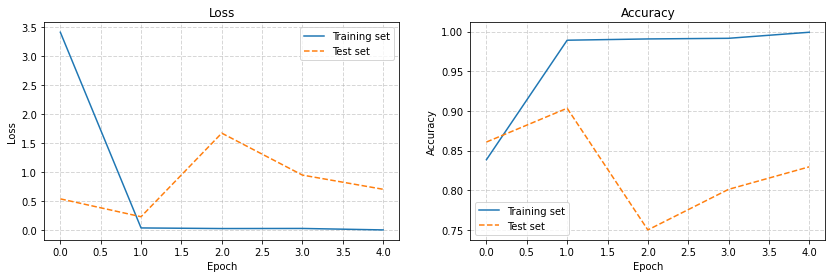

12/12 [==============================] - 1s 96ms/step - loss: 0.7054 - accuracy: 0.8280
Training loss:  0.005184298846870661
Training accuracy:  0.9960317611694336


Test loss:  0.7053697109222412
Test accuracy:  0.8279569745063782


In [ ]:
render_training_history(training_history)
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

### 2.2 MobileNet

MobileNets are based on a streamlined architecture that uses depth-wise separable convolutions to build light weight deep neural networks [[10]](https://arxiv.org/abs/1704.04861). MobileNetV2 is a significant improvement over MobileNetV1 and pushes the state of the art for mobile visual recognition including classification, object detection and semantic segmentation.

![image](https://1.bp.blogspot.com/-M8UvZJWNW4E/WsKk-tbzp8I/AAAAAAAAChw/OqxBVPbDygMIQWGug4ZnHNDvuyK5FBMcQCLcBGAs/s640/image5.png)

 MobileNetV2 builds upon the ideas from MobileNetV1 [1], using depthwise separable convolution as efficient building blocks. However, V2 introduces two new features to the architecture: 1) linear bottlenecks between the layers, and 2) shortcut connections between the bottlenecks1. The basic structure is shown below [[11]](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html).

![image](https://2.bp.blogspot.com/-E7CT0RHBWq4/WsKlTgEeX2I/AAAAAAAACh0/dp1B4yh6O2k4H1LuC7BA-EKzrL7W0L8iACLcBGAs/s640/image2.png)

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet

In [ ]:
pre_trained_model = MobileNet(input_shape = INPUT_IMG_SHAPE, 
                                include_top = False, 
                                weights = "imagenet")
pre_trained_model.trainable = False

In [ ]:
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [ ]:
pre_trained_model.output

<KerasTensor: shape=(None, 7, 7, 1024) dtype=float32 (created by layer 'conv_pw_13_relu')>

In [ ]:
x=pre_trained_model.output
# Add some new Fully connected layers to 
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(512,activation='relu')(x) 
x = tf.keras.layers.Dropout(0.25)(x)
preds=tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x) #final layer with softmax activation

model=tf.keras.Model(inputs=pre_trained_model.input,outputs=preds)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [ ]:
for layer in model.layers[:87]:
    layer.trainable=False
for layer in model.layers[87:]:
    layer.trainable=True

In [ ]:
training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        early_stopping_callback,
    ],
    verbose=1
)

Epoch 1/5
78/78 [==============================] - 37s 455ms/step - loss: 0.7016 - accuracy: 0.7558 - val_loss: 0.3623 - val_accuracy: 0.8949
Epoch 2/5
78/78 [==============================] - 36s 465ms/step - loss: 0.0202 - accuracy: 0.9934 - val_loss: 0.2321 - val_accuracy: 0.9517
Epoch 3/5
78/78 [==============================] - 35s 456ms/step - loss: 0.0351 - accuracy: 0.9859 - val_loss: 0.7906 - val_accuracy: 0.8210
Epoch 4/5
78/78 [==============================] - 35s 450ms/step - loss: 0.0098 - accuracy: 0.9965 - val_loss: 0.3024 - val_accuracy: 0.9403
Epoch 5/5
78/78 [==============================] - 33s 432ms/step - loss: 0.0278 - accuracy: 0.9910 - val_loss: 0.5089 - val_accuracy: 0.9062


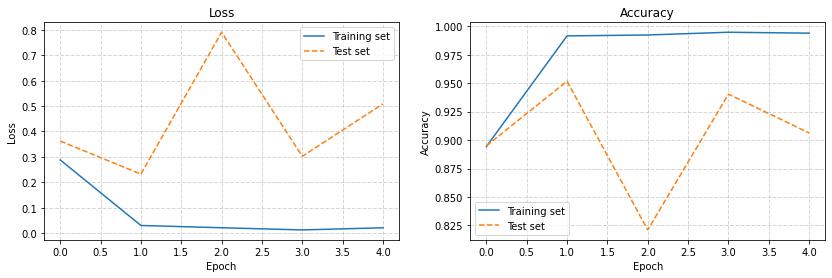

12/12 [==============================] - 1s 89ms/step - loss: 0.4818 - accuracy: 0.9113
Training loss:  0.001462299725972116
Training accuracy:  0.9996031522750854


Test loss:  0.4818101227283478
Test accuracy:  0.9112903475761414


In [ ]:
render_training_history(training_history)
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

### 2.3 Save Models

In [ ]:
model.save('saved_models/hands-mobilenet')

INFO:tensorflow:Assets written to: saved_models/hands-mobilenet/assets


INFO:tensorflow:Assets written to: saved_models/hands-mobilenet/assets


In [ ]:
new_model = tf.keras.models.load_model('saved_models/hands-mobilenet')
new_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

### 2.4 TensorFlow Hub
TensorFlow Hub is a repository of trained machine learning models ready for fine-tuning and deployable anywhere. Reuse trained models like BERT and Faster R-CNN with just a few lines of code.

TensorFlow Hub is an open repository and library for reusable machine learning. The tfhub.dev repository provides many pre-trained models: text embeddings, image classification models, TF.js/TFLite models and much more. The repository is open to community contributors [[11]](https://www.tensorflow.org/hub/overview).

Check out TF Hub [here](https://www.tensorflow.org/hub).